In [12]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8) # (w, h)

In [13]:
def sim_leverage(proxy, leverage=1, expense_ratio = 0.0, initial_value=1.0):
    """
    Simulates a leverage ETF given its proxy, leverage, and expense ratio.
    
    Daily percent change is calculated by taking the daily percent change of
    the proxy, subtracting the daily expense ratio, then multiplying by the leverage.
    """
    val = proxy['Close']
    pct_change = (val - val.shift(1)) / val.shift(1)
    pct_change = (pct_change - expense_ratio / 252) * leverage
    sim = (1 + pct_change).cumprod() * initial_value
    sim[0] = initial_value
    return sim


In [52]:
def process_yahoo_csv(file_name):
    df = pd.read_csv(file_name, 
                     parse_dates=True,
                     index_col=0)

    price_ratio = df['Adj Close']/df['Close']
    for column in ["Open", "High", "Low", "Close"]:
        df[column] = df[column]*price_ratio

    return df[["Open", "High", "Low", "Close", "Volume"]]


In [53]:
vfinx_df = process_yahoo_csv("VFINX.csv")
vustx_df = process_yahoo_csv("VUSTX.csv")
nasdaq_df = process_yahoo_csv("NASDAQ.csv")
# nasdaq_df['Close'] /= 100

upro_sim_df = vfinx_df.copy()
tmf_sim_df = vustx_df.copy()
tqqq_sim_df = nasdaq_df.copy()

upro_sim_df['Close'] = sim_leverage(upro_sim_df, leverage=3.0, expense_ratio=0.02)
tmf_sim_df['Close'] = sim_leverage(tmf_sim_df, leverage=3.0, expense_ratio=0.02)
tqqq_sim_df['Close'] = sim_leverage(tqqq_sim_df, leverage=3.0, expense_ratio=0.02)

for column in ["Open", "High", "Low"]:
    upro_sim_df[column] = upro_sim_df["Close"]
    tmf_sim_df[column] = tmf_sim_df["Close"]
    tqqq_sim_df[column] = tqqq_sim_df["Close"]
upro_sim_df["Volume"] = 0
tmf_sim_df["Volume"] = 0
tqqq_sim_df["Volume"] = 0



In [55]:
upro_sim_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
1980-01-02,1.000000,1.000000,1.000000,1.000000,0
1980-01-03,0.985118,0.985118,0.985118,0.985118,0
1980-01-04,1.022160,1.022160,1.022160,1.022160,0
1980-01-07,1.030407,1.030407,1.030407,1.030407,0
1980-01-08,1.092029,1.092029,1.092029,1.092029,0


In [17]:
start = datetime.datetime(1986, 5, 19)
end = datetime.datetime(2020, 4, 20)

upro_sim = bt.feeds.PandasData(dataname=upro_sim_df, fromdate=start, todate=end)
tmf_sim = bt.feeds.PandasData(dataname=tmf_sim_df, fromdate=start, todate=end)
vfinx = bt.feeds.PandasData(dataname=vfinx_df, fromdate=start, todate=end)
tqqq_sim = bt.feeds.PandasData(dataname=tqqq_sim_df, fromdate=start, todate=end)


In [18]:
class BuyAndHold(bt.Strategy):
    def next(self):
        if not self.getposition(self.data).size:
            self.order_target_percent(self.data, target=1.0)


In [19]:
def backtest(datas, strategy, plot=False, **kwargs):
    cerebro = bt.Cerebro()
    for data in datas:
        cerebro.adddata(data)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addstrategy(strategy, **kwargs)
    results = cerebro.run()
    if plot:
        cerebro.plot()
    return (results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'],
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'])


In [20]:
dd, cagr, sharpe = backtest([vfinx], BuyAndHold, plot=True)
print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")


<IPython.core.display.Javascript object>

Max Drawdown: 55.24%
CAGR: 9.63%
Sharpe: 0.635


In [21]:
dd, cagr, sharpe = backtest([upro_sim], BuyAndHold)
print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")


Max Drawdown: 97.83%
CAGR: 11.25%
Sharpe: 0.477


In [22]:
dd, cagr, sharpe = backtest([tmf_sim], BuyAndHold)
print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")


Max Drawdown: 53.13%
CAGR: 15.27%
Sharpe: 0.563


In [23]:
class AssetAllocation(bt.Strategy):
    params = (
        ('UPRO',0.3),
        ('TQQQ',0.1)
    )
    def __init__(self):
        self.UPRO = self.datas[0]
        self.TMF = self.datas[1]
        self.TQQQ = self.datas[2]
        self.counter = 0
        
    def next(self):
        if  self.counter % 20 == 0:
            self.order_target_percent(self.UPRO, target=self.params.UPRO)
            self.order_target_percent(self.TQQQ, target=self.params.TQQQ)
            self.order_target_percent(self.TMF, target=(1 - self.params.UPRO - self.params.TQQQ))
        self.counter += 1


In [13]:
dd, cagr, sharpe = backtest([upro_sim, tmf_sim, tqqq_sim], AssetAllocation, plot=True, UPRO=0.6, TQQQ=0)
print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")


Max Drawdown: 61.83%
CAGR: 19.48%
Sharpe: 0.677


In [28]:
sharpes = {}
for perc_equity in range(0, 101, 5):
    sharpes[perc_equity] = backtest([upro_sim, tmf_sim, tqqq_sim], AssetAllocation, UPRO=(perc_equity*0.6 / 100.0), TQQQ=(perc_equity*0.4 / 100.0))[2]


<IPython.core.display.Javascript object>


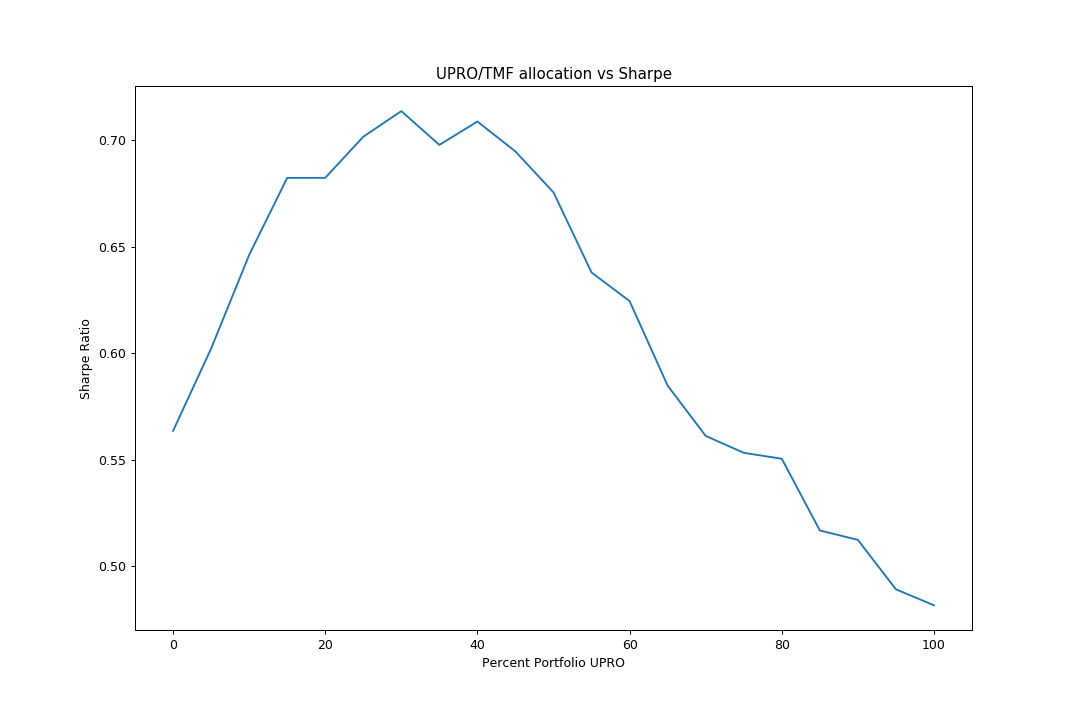

Max Sharpe of 0.714 at 30% UPRO


In [29]:
series = pd.Series(sharpes)
ax = series.plot(title="UPRO/TMF allocation vs Sharpe")
ax.set_ylabel("Sharpe Ratio")
ax.set_xlabel("Percent Portfolio UPRO");
print(f"Max Sharpe of {series.max():.3f} at {series.idxmax()}% UPRO")


In [23]:
dd, cagr, sharpe = backtest([upro_sim, tmf_sim, tqqq_sim], AssetAllocation, plot=True, UPRO=0.4, TQQQ=0)
print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")


Max Drawdown: 42.11%
CAGR: 17.54%
Sharpe: 0.684


<IPython.core.display.Javascript object>


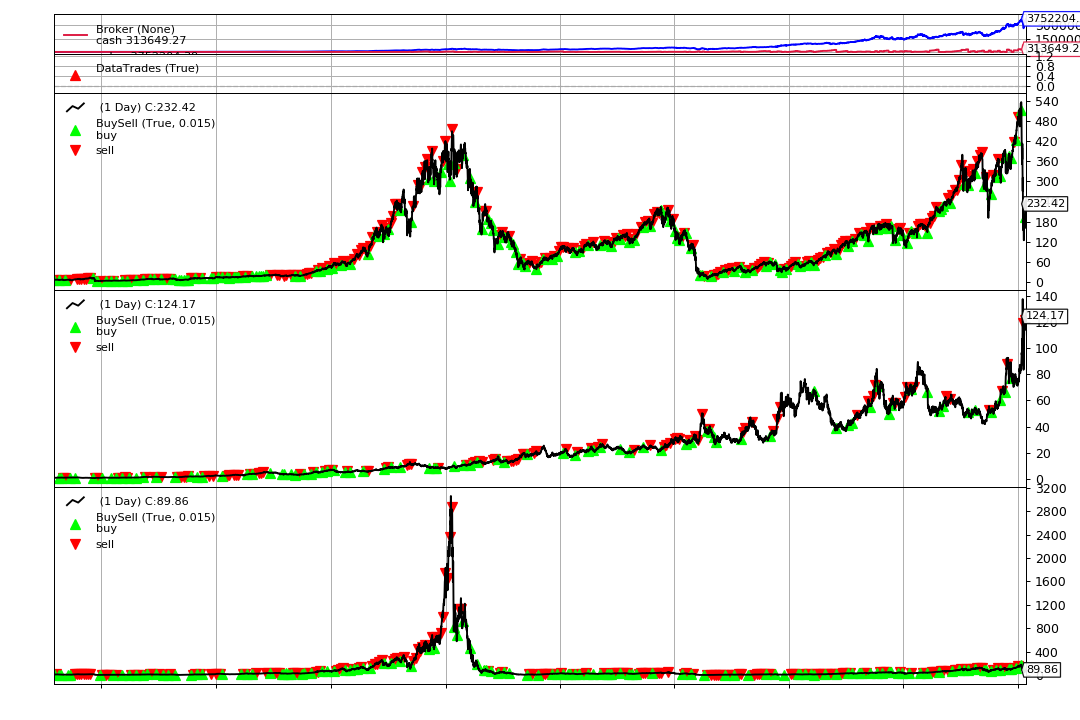

Max Drawdown: 52.18%
CAGR: 19.09%
Sharpe: 0.709


In [30]:
dd, cagr, sharpe = backtest([upro_sim, tmf_sim, tqqq_sim], AssetAllocation, plot=True, UPRO=0.24, TQQQ=0.16)
print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")


In [59]:
dd_all = []
sharpe_all = []
cagr_all = []
ratio_all = []
for start_year in range(1987, 2020):
    sharpe_start = []
    cagr_start = []
    dd_start = []
    ratio_start = []
    for end_year in range(start_year+2, 2021):
        sharpe_end = []
        cagr_end = []
        dd_end = []
        ratio_end = []

        start = datetime.datetime(start_year, 1, 1)
        end = datetime.datetime(end_year, 1, 1)

        upro_sim = bt.feeds.PandasData(dataname=upro_sim_df, fromdate=start, todate=end)
        tmf_sim = bt.feeds.PandasData(dataname=tmf_sim_df, fromdate=start, todate=end)
        vfinx = bt.feeds.PandasData(dataname=vfinx_df, fromdate=start, todate=end)
        tqqq_sim = bt.feeds.PandasData(dataname=tqqq_sim_df, fromdate=start, todate=end)
        for perc_equity in range(0, 101, 10):
            dd, cagr, sharpe = backtest([upro_sim, tmf_sim, tqqq_sim], AssetAllocation, UPRO=(perc_equity*0.6 / 100.0), TQQQ=(perc_equity*0.4 / 100.0))
            sharpe_end.append(sharpe)
            cagr_end.append(cagr)
            dd_end.append(dd)
            ratio_end.append(perc_equity)
            print(f"Start {start_year}, End {end_year}, %eq %{perc_equity}, Max Drawdown: {dd:.2f}, CAGR: {cagr:.2f}, Sharpe: {sharpe:.3f}")
        sharpe_start.append(sharpe_end)
        cagr_start.append(cagr_end)
        dd_start.append(dd_end)
        ratio_start.append(ratio_end)
    sharpe_all.append(sharpe_start)
    cagr_all.append(cagr_start)
    dd_all.append(dd_start)
    ratio_all.append(ratio_start)

dd_all = np.array(dd_all)
sharpe_all = np.array(sharpe_all)
cagr_all = np.array(cagr_all)
ratio_all = np.array(ratio_all)


1987-01-01 00:00:00
1988-01-01 00:00:00
1987
1988
0
42.836219935283296
-19.053998954262106
None


TypeError: unsupported format string passed to NoneType.__format__

In [34]:
np.set_printoptions(precision=3)
print(np.array(sharpe_all))

[[[0.719 0.731 0.734 0.726 0.709 0.666]
  [0.667 0.675 0.677 0.667 0.648 0.609]
  [0.689 0.663 0.632 0.597 0.561 0.516]]

 [[0.789 0.79  0.768 0.737 0.716 0.686]
  [0.731 0.728 0.706 0.676 0.653 0.624]
  [0.753 0.718 0.658 0.605 0.57  0.532]]

 [[0.818 0.832 0.834 0.815 0.79  0.769]
  [0.753 0.762 0.756 0.741 0.717 0.698]
  [0.775 0.743 0.699 0.656 0.612 0.581]]]


In [49]:
upro_sim.__dict__

{'params': <backtrader.metabase.AutoInfoClass_LineRoot_LineMultiple_LineSeries_DataSeries_OHLC_OHLCDateTime_AbstractDataBase_DataBase_PandasData at 0x1823c7512e0>,
 'p': <backtrader.metabase.AutoInfoClass_LineRoot_LineMultiple_LineSeries_DataSeries_OHLC_OHLCDateTime_AbstractDataBase_DataBase_PandasData at 0x1823c7512e0>,
 '_owner': None,
 'plotinfo': <backtrader.metabase.AutoInfoClass_pi_LineSeries_pi_DataSeries_pi_OHLC_pi_OHLCDateTime_pi_AbstractDataBase_pi_DataBase_pi_PandasData at 0x1823c751370>,
 'lines': <backtrader.lineseries.Lines_LineSeries_DataSeries_OHLC_OHLCDateTime_AbstractDataBase_DataBase_PandasData at 0x1823c751a30>,
 'plotlines': <backtrader.metabase.AutoInfoClass_pl_LineSeries_pl_DataSeries_pl_OHLC_pl_OHLCDateTime_pl_AbstractDataBase_pl_DataBase_pl_PandasData at 0x1823c7510a0>,
 'l': <backtrader.lineseries.Lines_LineSeries_DataSeries_OHLC_OHLCDateTime_AbstractDataBase_DataBase_PandasData at 0x1823c751a30>,
 'line': <backtrader.linebuffer.LineBuffer at 0x1823f13d0a0>,
 